In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import logomaker as lm
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.misc import index_to_sample_df, downsample_raw_input, read_tRNAdb_info, sample_df_to_dict
from src.read_processing import AR_merge, BC_split, Kmer_analysis, BC_analysis, UMI_trim
from src.alignment import SWIPE_align
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.transcript_mutations import TM_analysis

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
seq_dir = 'raw_fastq'
seq_dir_noDS = seq_dir # Not downsampled

# These folder names are used in subsequent processing steps
# to dump data. Best to not change:
AdapterRemoval_dir = 'AdapterRemoval'
BC_dir = 'BC_split'
UMI_dir = 'UMI_trimmed'
align_dir = 'SWalign'
stats_dir = 'stats_collection'
TM_dir = 'transcript_mutations'
plotting_dir = 'plotting'
tRNA_database = dict()
tRNA_database['human'] = '{}/tRNA_database/human/hg38-tRNAs.fa'.format(homedir)
tRNA_database['mouse'] = '{}/tRNA_database/mouse/mm10-tRNAs.fa'.format(homedir)
# Read information (length, codon etc) of tRNAs into dictionary:
tRNA_data = read_tRNAdb_info(tRNA_database)
SWIPE_score_mat = '{}/utils/nuc_score-matrix.txt'.format(homedir)
SWIPE_score_mat2 = '{}/utils/nuc_score-matrix_2.txt'.format(homedir) # For masked reference sequences
# tRNA sequencing yields many duplicated reads.
# Adding these commonly seen sequences to a list prevents duplicated alignment:
common_seqs = '{}/utils/common-seqs.fasta.bz2'.format(homedir)
# ^^ That one is too big, take the top 1k instead:
common_seqs = '{}/utils/common-seqs_1k.fasta.bz2'.format(homedir)

# Define minimum read length based on minimum insert size:
MIN_INSERT_LEN = 20
UMI_LEN = 10
BC_MAX_LEN = 19
MIN_READ_LEN = MIN_INSERT_LEN + UMI_LEN + BC_MAX_LEN
print('Using minimum read length: {} (after merge)'.format(MIN_READ_LEN))

# The minimum alignment score.
# The alignment score is calculated as 1 per match,
# -2 per mismatch, -6 per gap opening and -1 per gap extension.
# Better to set relatively low, since additional filtering can
# be applied later.
MIN_SCORE_ALIGN = 20
print('Using minimum alignemnt score: {}'.format(MIN_SCORE_ALIGN))

# Read index information:
index_list_fnam = 'index_list.xlsx'
index_df = pd.read_excel('{}/utils/{}'.format(homedir, index_list_fnam))

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_third-gen
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq
Using minimum read length: 49 (after merge)
Using minimum alignemnt score: 20


### Settings

In [4]:
sample_list_fnam = 'sample_list_P1-2-3.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Add barcode sequences:
sample_df = index_to_sample_df(sample_df, index_df)
# Read elementary info (replicate, barcode, species)
# for each unique sample name into a dictionary:
sample_dict = sample_df_to_dict(sample_df)
# Get filenames from the sample information:
inp_file_df = sample_df[['fastq_mate1_filename', 'fastq_mate2_filename', 'P5_index', 'P7_index', 'P5_index_seq', 'P7_index_seq']].copy().drop_duplicates().reset_index(drop=True)

# Downsample:
if True:
    sample_df, inp_file_df, seq_dir = downsample_raw_input(sample_df, inp_file_df, NBdir, data_dir, seq_dir_noDS, downsample_absolute=5e5)

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                seq_dir = seq_dir,
                AdapterRemoval_dir = AdapterRemoval_dir,
                BC_dir = BC_dir,
                UMI_dir = UMI_dir,
                align_dir = align_dir,
                stats_dir = stats_dir,
                TM_dir = TM_dir,
                plotting_dir = plotting_dir)

In [5]:
# Run AdapterRemoval:
AR_obj = AR_merge(dir_dict, inp_file_df, MIN_READ_LEN)
AdapterRemoval_dir_abs = AR_obj.make_dir(overwrite=True)
# inp_file_df = AR_obj.run_serial()
inp_file_df = AR_obj.run_parallel(n_jobs=4, overwrite=True)

In [6]:
# Split files based on barcodes:
BCsplit_obj = BC_split(dir_dict, sample_df, inp_file_df)
BC_dir_abs = BCsplit_obj.make_dir(overwrite=True)
# sample_df, inp_file_df = BCsplit_obj.run_serial()
sample_df, inp_file_df = BCsplit_obj.run_parallel(n_jobs=4, overwrite=True)

In [7]:
### Perform Kmer analysis on unmapped reads ###
if False: # barcode analysis is typically suficient 
    kmer_obj = Kmer_analysis(dir_dict, inp_file_df, index_df)
    # Add a filter to avoid Kmers from the end of tRNA sequences:
    kmer_obj.filter_3p_fasta(tRNA_database['human'])
    # Add to this filter the constant region of the adapters:
    kmer_obj.filter_window_BC(filter_window=(0, 11))
    # Search for Kmers:
    all_kmer = kmer_obj.search_unmapped(search_size=13)

In [8]:
### Perform barcode analysis on unmapped reads ###
# Recall that adapters look like this:
# GGCTGCCATGC    GACTA
# GGCTGCCATGCA   AGTGC
# GGCTGCCATGCTG  TCACG
# GGCTGCCATGCAAC CTGAT
# With the barcode as the rightmost 5 nt.
# Search these 5 nt. barcodes by specifying BC_size_3p=5
bc_analysis_obj = BC_analysis(dir_dict, inp_file_df, index_df, BC_size_3p=5, overwrite=True)
# Search for barcodes in the unmapped reads.
# For the summary output, filter by a max distance
# to any barcode of 1 (group_dist=1), then group by barcode name:
bc_analysis_df = bc_analysis_obj.search_unmapped(group_dist=1, overwrite=True)
bc_analysis_df

,Name,Count
0,l5Sp,26700
1,l4Sp,10041
2,l10Sp,6808
3,l6Sp,6016
4,l1Sp,5905
5,l3Sp,5826
6,l8Sp,5806
7,l12Sp,5783
8,l9Sp,5434
9,l2Sp,4797


In [9]:
### Generate UMI stats and write final trimmed tRNA sequences ###
# Note, the cDNA input amount is so large that it is very unlikely to sequence
# the same PCR amplified DNA twice. Therefore, this processing step does not
# attempt to merge possible UMI duplicates.
UMItrim_obj = UMI_trim(dir_dict, sample_df)
UMI_dir_abs = UMItrim_obj.make_dir(overwrite=True)
# sample_df = UMItrim_obj.run_serial()
sample_df = UMItrim_obj.run_parallel(n_jobs=4, overwrite=True)
sample_df.head(3)

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-500k.fastq.bz2,P1_R2_DSA-500k.fastq.bz2,46652,2106,44255,46361,99.376233,95.457389,45900,37221,43948.202015,98.388065,84.692885
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-500k.fastq.bz2,P2_R2_DSA-500k.fastq.bz2,35150,1294,33661,34955,99.445235,96.298098,34621,28011,33502.694907,98.495021,83.608200
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-500k.fastq.bz2,P3_R2_DSA-500k.fastq.bz2,36506,1718,34501,36219,99.213828,95.256633,35923,29454,34719.984436,98.403002,84.832987


In [10]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database, sample_df, SWIPE_score_mat, gap_penalty=6, extension_penalty=1, min_score_align=20, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=True)
# sample_df = align_obj.run_serial(dry_run=False, verbose=False, overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=4)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  100p4  100p2  100p3  100p1  85p4  85p2  85p3  85p1  70p3  70p2  70p1  55p1  55p3  55p4  70p4  40p1  40p2  55p2  40p4  25p2  25p4  10p1  25p1  25p3  10p4  40p3  10p2  0p2  10p3  0p3  0p_90m2  0p4  0p1  0p_90m1  0p_90m4  0p_90m3  common-seqs

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-500k.fastq.bz2,P1_R2_DSA-500k.fastq.bz2,46652,2106,44255,46361,99.376233,95.457389,45900,37221,43948.202015,98.388065,84.692885,45479.0,73.724136,26.275864,99.082789
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-500k.fastq.bz2,P2_R2_DSA-500k.fastq.bz2,35150,1294,33661,34955,99.445235,96.298098,34621,28011,33502.694907,98.495021,83.608200,34199.0,75.075295,24.924705,98.781087
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-500k.fastq.bz2,P3_R2_DSA-500k.fastq.bz2,36506,1718,34501,36219,99.213828,95.256633,35923,29454,34719.984436,98.403002,84.832987,34788.0,72.424399,27.575601,96.840464


In [11]:
### Collect alignment statistics ###
stats_obj = STATS_collection(dir_dict, tRNA_data, sample_df, common_seqs=common_seqs)
stats_dir_abs = stats_obj.make_dir(overwrite=True)
# stats_df = stats_obj.run_serial()
stats_df = stats_obj.run_parallel(n_jobs=4)
# The dataframe returned is the "ALL_stats_aggregate_filtered.csv"
# which is the aggregated data filtered to contain only the
# most relevant columnns and requiring the 3' must be covered
# and have no 3' non-template bases.
# The CSV file output "ALL_stats_aggregate.csv" is the data
# aggregated based on all values identical except
# readID, 5p_UMI and 3p_BC. I.e. every information, except
# the UMI seequence is maintained in the aggregated CSV.
stats_df.head(3)

Using common sequences...

/Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/src/stats_collection.py:112: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  stat_df = pd.read_csv(stats_fh, keep_default_na=False)


  40p2  40p3  25p3  25p4  10p1  40p4  25p1  25p2  0p1  10p2  10p3  0p2  10p4  0p3  0p_90m3  0p4  0p_90m1  0p_90m2  0p_90m4

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,align_3p_nt,codon,anticodon,amino_acid,count
0,0p1,0p,1,l5Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,C,AAA,TTT,eColiLys,12
1,0p1,0p,1,l5Sp,Homo_sapiens_mito_tRNA-Ala-TGC,72,True,C,GCA,TGC,Ala,37
2,0p1,0p,1,l5Sp,Homo_sapiens_mito_tRNA-Arg-TCG,68,True,A,CGA,TCG,Arg,1


In [252]:
### Generate standard tRNAseq data plots ###
plot_obj = TRNA_plot(dir_dict, sample_df, pull_default=True)
plotting_dir_abs = plot_obj.make_dir(overwrite=False)
plot_obj.get_charge_df()

# Plot UMI nucleotide content logo per sample:
#plot_obj.plot_UMI_logo()

# Plot the 5p non-template nucleotide logo per sample,
# using only those at, or below, the legth determined as a percentile:
#plot_obj.plot_non_temp('5p', '_5p-non-template_logo', seq_len_percentile=99)

# 3p non-template nucleotides are more rare, therefore 99.9 percentile:
#plot_obj.plot_non_temp('3p', '_3p-non-template_logo', seq_len_percentile=99.9)

# 3p non-template nucleotides, but require 3p coverage.
# This is more likely to reflect either:
# 1) Erronous CCA addition, or 2) additional bases in the adapter.
#plot_obj.plot_non_temp('3p', '_3p-non-template_3p-cover_logo', seq_len_percentile=99.9, _3p_cover=True)

# Plot the 5p to 3p coverage for each amino acid:
#plot_obj.plot_coverage(compartment='cyto', plot_type='needle', aa_norm=False, plot_name='cov_plot_cyto_needle')
#plot_obj.plot_coverage(compartment='mito', plot_type='needle', aa_norm=False, plot_name='cov_plot_mito_needle')
#plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', aa_norm=False, plot_name='cov_plot_cyto_behrens')
#plot_obj.plot_coverage(compartment='mito', plot_type='behrens', aa_norm=False, plot_name='cov_plot_mito_behrens')
#plot_obj.plot_coverage(compartment='cyto', plot_type='needle', aa_norm=False, #plot_name='cov_plot_cyto_needle_100p', sample_list=['100p1', '100p2', '100p3', '100p4'])
#plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', y_norm=True, plot_name='cov_plot_cyto_behrens_norm')



Folder exists and overwrite set to false... Doing nothing.


In [255]:
plot_obj.plot_abundance(bc_list_exl=['l4Sp', 'l7Sp'], charge_plot=False)


Now plotting sample:  100p  85p  70p  55p  40p  25p  10p  0p  0p_90m

In [221]:
#agg_df = pd.read_csv('/Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_third-gen/data/stats_collection/ALL_stats_aggregate.csv', keep_default_na=False)
agg_df = copy.deepcopy(plot_obj.all_stats)
agg_df.head(2)

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,align_score,unique_annotation,tRNA_annotation_len,align_5p_idx,align_3p_idx,align_5p_nt,align_3p_nt,5p_cover,3p_cover,5p_non-temp,3p_non-temp,codon,anticodon,amino_acid,count,single_codon,mito_codon,Ecoli_ctr,AA_letter
0,100p1,100p,1,l1Sp,Homo_sapiens_mito_tRNA-Arg-TCG,64,True,68,2,68,G,A,False,True,,,CGA,TCG,Arg,1,True,True,False,R
1,100p1,100p,1,l1Sp,Homo_sapiens_mito_tRNA-Asn-GTT,70,True,76,1,76,T,A,True,True,TTT,,AAC,GTT,Asn,1,True,True,False,N


In [ ]:
# Use the TM_analysis to find the most mutated positions in the tRNA transcripts.
# Then generate a new version of the tRNA transcripts database with these positions masked
# Then, using the masked sequences, re-run the alignment, stats collected and plotting

# Re-run using gap_open = -3 and gap_extension = -2 to reflect how gaps are more tolerated

### The masked tRNA database will only be used for alignment
# All other steps will use the old unmasked database

In [623]:
### Perform transcript mutation analysis ###
TM_obj = TM_analysis(dir_dict, sample_df, tRNA_database, pull_default=True, common_seqs=common_seqs, ignore_common_count=True)
TM_dir_abs = TM_obj.make_dir(overwrite=True)

#TM_obj.find_muts(n_jobs=4, sample_list=['70p1', '70p2', '70p3', '70p4'])
TM_obj.find_muts(n_jobs=4, unique_anno=True)
#TM_obj.find_muts(n_jobs=4)
TM_obj.fix_end()

#TM_obj.plot_transcript_logo()



# tr_mut_out = TM_obj.plot_transcript_mut(topN=30, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat', min_count_show=10)
#tr_mut_out = TM_obj.plot_transcript_mut(topN=30, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat2')


#tr_cov_out = TM_obj.plot_transcript_cov(topN=40, no_plot_return=False, mito=False, plot_name='test_heat_cov', sort_rows=True)
#tr_mut_out = TM_obj.plot_transcript_mut(topN=40, no_plot_return=False, mito=False, gap_only=False, plot_name='test_heat2', sort_rows=tr_cov_out[2])


TM_obj.mask_tRNA_database(min_mut_freq=0.5, min_pos_count=50, min_tr_count=100, frac_max_score=0.90)

tRNA_database_masked = TM_obj.write_masked_tRNA_database(out_dir='tRNA_database_masked')

Using common sequences...

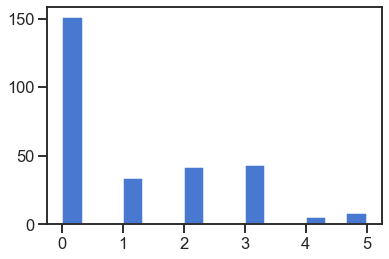

In [615]:
plt.hist(TM_obj.mask_stats['human']['mask_count'], bins=15);

In [616]:
TM_obj.mask_stats['human']

{'mask_count': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 5, 0, 0, 0, 5, 0, 3, 0, 3, 2, 3, 0, 5, 0, 3, 3, 2, 0, 3,
        3, 3, 3, 2, 0, 2, 5, 5, 4, 2, 2, 2, 2, 2, 2, 0, 2, 4, 2, 4, 0, 1,
        0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1,
        1, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0,
        0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 4, 4, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3, 3,
        3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2]),
 'mask_sum': 307,
 'mask_mean':

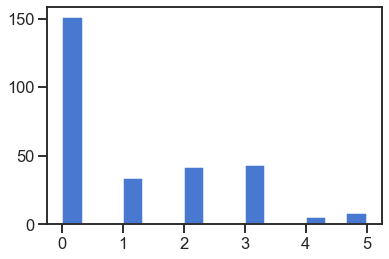

In [617]:
plt.hist(TM_obj.mask_stats['human']['mask_count'], bins=15);

In [576]:
TM_obj.mask_stats['human']

{'mask_count': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  5,  0,  0,  0,  5,  0,  4,  0,  4,
         0,  4,  0,  5,  0,  4,  4,  0,  0,  5,  5,  5,  5,  3,  0,  3,  5,
         5,  4,  2,  0,  0,  0,  0,  0,  0,  0,  4,  0,  4,  0,  0,  0,  0,
         0,  0,  5,  0,  0,  0,  5,  5,  0,  0,  0,  5,  5,  5,  5,  4,  0,
         5,  4,  2,  2,  2,  2,  3,  3,  2,  3,  3,  3,  2,  3,  3,  2,  3,
         3,  3,  0,  0,  3,  3,  3,  2,  3,  3,  3,  2,  2,  2,  2,  2,  0,
         0,  3,  3,  3,  0,  1,  1,  3,  5,  3,  5,  5,  1,  1,  0,  1,  1,
         1,  0,  0,  1,  1,  1,  1,  2,  4,  0,  4,  4,  4,  4,  4,  4,  3,
         0,  0,  3,  3,  3,  4,  4,  4,  4,  3,  3,  3,  3,  0,  0,  5,  5,
         2,  0,  0,  0,  4,  4,  0,  1,  0,  0,  1,  1,  1,  1,  0,  0,  0,
         1,  0,  4,  4,  4,  4,  1,  1,  0,  3,  0,  3,  3,  0,  0, 13, 13,
        13, 13,  0,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0

In [599]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database, sample_df, SWIPE_score_mat2, gap_penalty=3, extension_penalty=2, min_score_align=20, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=True)
# sample_df = align_obj.run_serial(dry_run=False, verbose=False, overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=4)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  100p2  100p1  100p3  100p4  85p4  85p2  85p3  85p1  70p3  70p2  70p1  55p1  55p3  55p4  70p4  40p1  40p2  55p2  25p1  40p4  25p2  10p1  25p4  10p3  10p2  25p3  0p2  40p3  0p4  0p1  10p4  0p3  0p_90m4  0p_90m1  0p_90m2  0p_90m3  common-seqs

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-10k.fastq.bz2,P1_R2_DSA-10k.fastq.bz2,944,38,902,940,99.576271,95.957447,931,866,930.174768,98.622881,93.100784,922.0,74.511931,25.488069,99.033298
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-10k.fastq.bz2,P2_R2_DSA-10k.fastq.bz2,673,14,648,662,98.365527,97.885196,663,622,662.581602,98.514116,93.875230,653.0,73.813170,26.186830,98.491704
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-10k.fastq.bz2,P3_R2_DSA-10k.fastq.bz2,709,35,666,701,98.871650,95.007133,692,633,691.544180,97.602257,91.534282,674.0,72.848665,27.151335,97.398844


In [618]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database_masked, sample_df, SWIPE_score_mat2, gap_penalty=3, extension_penalty=2, min_score_align=20, common_seqs=common_seqs)
align_dir_abs = align_obj.make_dir(overwrite=True)
# sample_df = align_obj.run_serial(dry_run=False, verbose=False, overwrite=False)
sample_df = align_obj.run_parallel(n_jobs=4)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Running Swipe on:  100p1  100p3  100p2  100p4  85p4  85p2  85p3  70p3  85p1  70p1  70p2  55p1  55p2  55p4  40p1  70p4  40p2  55p3  40p3  25p3  25p4  10p1  25p1  25p2  10p4  10p2  10p3  40p4  0p2  0p1  0p3  0p4  0p_90m1  0p_90m3  0p_90m2  0p_90m4  common-seqs

,sample_name_unique,sample_name,replicate,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,fastq_mate1_filename,fastq_mate2_filename,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,Mapping_percent
0,100p1,100p,1,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,P1_R1_DSA-10k.fastq.bz2,P1_R2_DSA-10k.fastq.bz2,944,38,902,940,99.576271,95.957447,931,866,930.174768,98.622881,93.100784,927.0,75.512406,24.487594,99.570354
1,100p2,100p,2,D501,D702,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,TCCGGAGA,GGCTGCCATGCAAGTGC,P2_R1_DSA-10k.fastq.bz2,P2_R2_DSA-10k.fastq.bz2,673,14,648,662,98.365527,97.885196,663,622,662.581602,98.514116,93.875230,656.0,72.713415,27.286585,98.944193
2,100p3,100p,3,D501,D703,l3Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,P3_R1_DSA-10k.fastq.bz2,P3_R2_DSA-10k.fastq.bz2,709,35,666,701,98.871650,95.007133,692,633,691.544180,97.602257,91.534282,677.0,73.264402,26.735598,97.832370


In [13]:
%%bash
pwd

/Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/tRNAseq_third-gen


In [15]:
%%bash
ls data

AdapterRemoval
BC_split
SWalign
UMI_trimmed
raw_fastq
raw_fastq_DSA-10k
stats_collection
stats_filtered_CC-CCA-aggregate.csv
stats_strict_filtered_CC-CCA-aggregate.csv


In [19]:
def plot_sample_vs_sample(SN1_ls, SN2_ls, df_charge, df_charge_melt, var='charge', amino_acid='all', transcript='all', min_obs=50, xyrange='percentile'):
    '''
    var = [charge, RPM]
    charge = CCA/(CCA+CC)
    RPM = reads per million i.e. how many reads of a given transcript annotation observed per million reads
    '''

    var1 = '{}_1'.format(var)
    var2 = '{}_2'.format(var)
    
    fig, axes = plt.subplots(ncols=len(SN1_ls), figsize=(6.5*len(SN1_ls), 5))
    try:
        len(axes)
    except:
        axes = [axes]

    ax_i = 0
    for SN1, SN2 in zip(SN1_ls, SN2_ls):
        mask1 = np.array([False]*len(df_charge))
        for SN1_i in SN1.split('+'):
            mask1 = mask1 | (df_charge['sample_name'] == SN1_i)
        #mask1 = (df_charge['sample_name'] == SN1)

        mask2 = np.array([False]*len(df_charge))
        for SN2_i in SN2.split('+'):
            mask2 = mask2 | (df_charge['sample_name'] == SN2_i)
        #mask2 = (df_charge['sample_name'] == SN2)

        m12 = pd.merge(
            df_charge[mask1],
            df_charge[mask2],
            how="inner",
            on='tRNA_annotation',
            left_index=False,
            right_index=False,
            sort=True,
            suffixes=("_1", "_2"),
            copy=True,
            indicator=False,
            validate=None,
        )


        min_mask = (m12['Ncharge_1'] > min_obs) & (m12['Ncharge_2'] > min_obs)
        x_vals = m12[min_mask][var1].values
        y_vals = m12[min_mask][var2].values
        xy_vals = np.array([x_vals, y_vals])
        # xy_min = 0
        # xy_max = max(xy_vals)
        if xyrange == 'percentile':
            xy_min = np.percentile(xy_vals, 3)
            xy_max = np.percentile(xy_vals, 97)
        else:
            xy_min, xy_max = xyrange
            
        

        g1 = sns.regplot(ax=axes[ax_i], data=m12[min_mask], x=var1, y=var2)
        if var == 'charge':
            g1.set_xlabel('% charge (sample={})'.format(SN1))
            g1.set_ylabel('% charge (sample={})'.format(SN2))
            g1.set_title('Charge vs. charge (min obs = {})'.format(min_obs))
            axes[ax_i].set(ylim=[xy_min, xy_max])
            axes[ax_i].set(xlim=[xy_min, xy_max])
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        elif var == 'RPM':
            g1.set_xlabel('RPM (sample={})'.format(SN1))
            g1.set_ylabel('RPM (sample={})'.format(SN2))
            g1.set_title('RPM vs. RPM (min obs = {})'.format(min_obs))
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        elif var == 'logRPM':
            g1.set_xlabel('log(RPM) (sample={})'.format(SN1))
            g1.set_ylabel('log(RPM) (sample={})'.format(SN2))
            g1.set_title('RPM vs. RPM (min obs = {})'.format(min_obs))
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        ax_i += 1
        


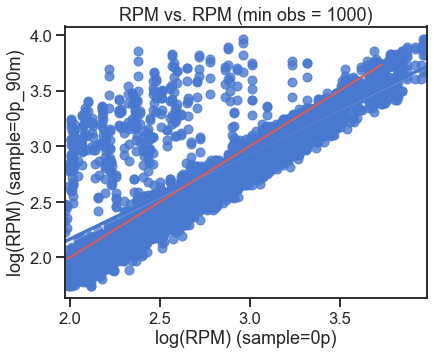

In [34]:
plot_sample_vs_sample(['0p'], ['0p_90m'], df_charge, df_charge_melt, min_obs=1000, var='logRPM')

In [55]:
# No normalization

plot_groups = set(df_charge['plot_group'].values)
for plot_group in plot_groups:
    Ngrp = len(set(df_charge[(df_charge['plot_group'] == plot_group)]['hue_order'].values))

    fig = plt.figure(figsize=(28/3*Ngrp, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    #mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 100) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 500) & (df_charge['single_codon']) & (df_charge['unique_annotation'])
    if sum(mask) == 0:
        continue
    hue_order = [t[0] for t in sorted(dict(zip(df_charge[mask]['hue_value'].values, df_charge[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
    
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    old_legend = g1.legend_
    handles = old_legend.legendHandles
    labels = hue_order
    title = df_charge[mask]['hue_name'].values[0]
    g1.legend(handles, labels, title=title, bbox_to_anchor=(1.01,1), borderaxespad=0)
 
    # mito tRNAs
    # mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] ==  plot_group) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 500) & (df_charge['single_codon']) & (df_charge['unique_annotation'])
    if sum(mask) == 0:
        continue
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
    g2.legend_.remove()

    plt.tight_layout()
    fig.savefig('{}.pdf'.format(plot_group))
    fig.clear()
    g1.clear()
    g2.clear()


<Figure size 8064x648 with 0 Axes>

<Figure size 8064x648 with 0 Axes>

<Figure size 8064x648 with 0 Axes>

<Figure size 6048x648 with 0 Axes>